
*    Os conjuntos de dados contêm transações feitas por cartões de credito em setembro de 2013 por titulares de cartões europeus
*    Este conjunto de dados apresenta as transações que ocorreram em dois dias, onde temos 492 fraudes em 284.807 transações. O Conjunto de dados é altamente desiquilibrado, a classe positiva (fraude) é responsvel por 0,172% de todas as transações.


*    Ele contém apenas variaveis de entrada númericas que são o resultado de uma trasnformação PCA. Infelizmente, devido a questões de confidencialidade, não podemos fornecer os recursos originais e mais informações básicas sobre os dados. Os recursos V1, V2... V28 são componentes principais obtidos com o PCA, os unicos recursos que não foram transformados com o PCA são: Tempo e Quantidade
*    O recurso "Tempo" contém os segundos decorridos entre cada transação e a primeira transação no conjunto de dados. O recurso "Amount" é o Amount da transação, esse recurso pode ser usado, por exemplo, para estudos diversos.

*    O recurso "Classe" é a variavel de resposta e assume o valor 1 em caso de fraude e 0 em caso contrário.


PCA - Uma técnica de aprendizagem não supervisionada, no qual você tem um dataset de alta dimensão e você diminue essa dimensionalidade, nossa dimensionalidade são 28 atributos, oque significa que anteriormente tinhamos centenas de atributos e foi reduzido a 28

PCA - Principal componente analise, analise de componente principal


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve


In [31]:
from google.colab import drive
drive.mount('/content/drive')  # Montar o Drive

# Caminho do ficheiro na raiz do Drive
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

print("Primeiras linhas do dataset:")
print(df.head())
print("\nInformações do dataset:")
print(df.info())
print("\nVerificar valores ausentes:")
print(df.isnull().sum().max())

Primeiras linhas do dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

Distribuição das classes:
Class
0    284315
1       492
Name: count, dtype: int64

Porcentagem de fraudes: 0.1727%


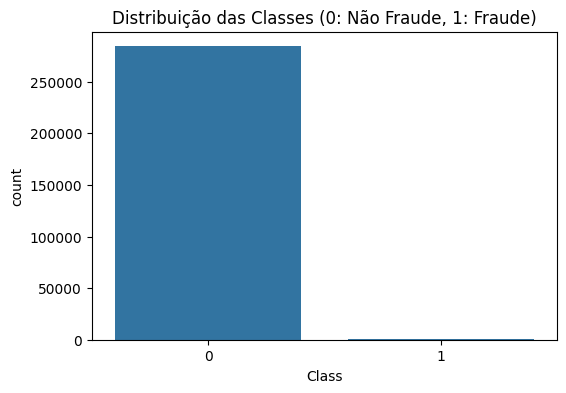

In [ ]:
# Verificar balanceamento das classes
print("Distribuição das classes:")
print(df['Class'].value_counts())
print("\nPorcentagem de fraudes: {:.4f}%".format((df[df['Class'] == 1].shape[0] / df.shape[0]) * 100))

# Plotar gráfico de barras
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Distribuição das Classes (0: Não Fraude, 1: Fraude)')
plt.show()

In [32]:
# Normalizar as colunas 'Time' e 'Amount'
scaler = StandardScaler()
df['Normalized_Amount'] = scaler.fit_transform(df[['Amount']])
df['Normalized_Time'] = scaler.fit_transform(df[['Time']])

# Remover colunas originais
df = df.drop(['Time', 'Amount'], axis=1)
print("Dataset após normalização:")
print(df.head())

Dataset após normalização:
         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  N

In [33]:
# Separar features e target
X = df.drop('Class', axis=1)
y = df['Class']

# Dividir em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de teste:", X_test.shape)

Tamanho do conjunto de treino: (199364, 30)
Tamanho do conjunto de teste: (85443, 30)


In [ ]:
# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("Distribuição das classes após SMOTE:")
print(pd.Series(y_train_bal).value_counts())

Distribuição das classes após SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64


In [ ]:
# Treinar o modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
print("Modelo treinado com sucesso!")

Modelo treinado com sucesso!


In [27]:
from sklearn.metrics import accuracy_score

# Fazer previsões
y_pred = rf_model.predict(X_test)

# Calcular acurácia do modelo
accuracy = accuracy_score(y_test, y_pred)

# Mostrar acurácia
print(f"Acurácia do Modelo: {accuracy:.4f}")


Acurácia do Modelo: 0.9994


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.86      0.78      0.82       148

    accuracy                           1.00     85443
   macro avg       0.93      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443

Matriz de Confusão:
[[85276    19]
 [   33   115]]
AUC-ROC: 0.9488861788102659


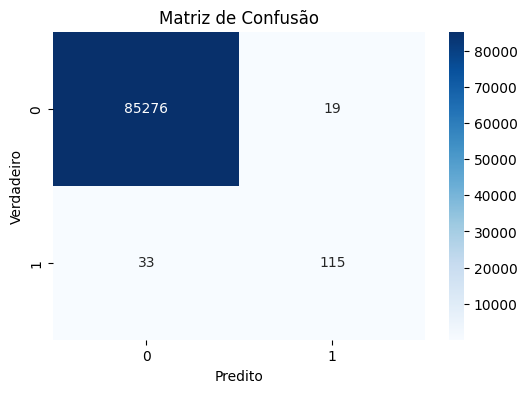

In [ ]:
# Fazer previsões
y_pred = rf_model.predict(X_test)

# Imprimir relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Imprimir matriz de confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Calcular AUC-ROC
y_pred_proba = rf_model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", auc)

# Plotar matriz de confusão
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

In [28]:
import joblib

# Salvar o modelo
joblib.dump(rf_model, 'rf_model.pkl')
# Salvar o scaler
joblib.dump(scaler, 'scaler.pkl')
print("Modelo e scaler salvos com sucesso!")

Modelo e scaler salvos com sucesso!


In [29]:
from google.colab import files

# Fazer download dos ficheiros
files.download('rf_model.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>